In [1]:
import pandas as pd

from data.teamExperiments import prepareData
import os

os.chdir('/Users/thom/Personnel/Scolaire/MIA/snake2-beta-insa-main/data/teamExperiments')

from sklearn import model_selection
from sklearn.linear_model import (
    LogisticRegression,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import (
    KNeighborsClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
)
import xgboost
from mlxtend.classifier import (
    StackingClassifier
)

from trainClassifiers import*
from sklearn.metrics import confusion_matrix, precision_score

### Data Preparation

In [2]:
classifiersDB = newClassifiersDatabase()


----------------
Creation of classifiers training dataset
----------------



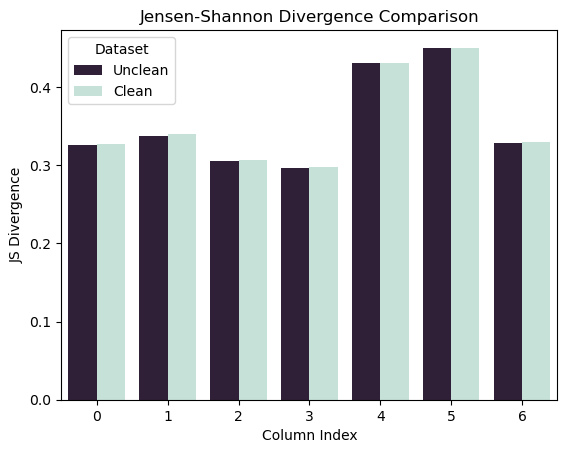

KeyboardInterrupt: 

KeyboardInterrupt: 

In [3]:
print("\n----------------\nCreation of classifiers training dataset\n----------------\n")
%run classification/makeClassifierTrainingDataset.ipynb
print("\n----------------\nTraining of classifiers\n----------------\n")

In [100]:
trainingSet

,0,1,2,3,4,5,6,isMember
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
458695,0,0,0,0,0,0,0,0
925276,0,0,0,0,0,0,0,0
593491,0,0,0,0,0,0,0,0
694759,0,0,0,0,0,0,0,0


In [101]:
X_train, X_test, y_train, y_test = prepareData.get_train_test_X_y(trainingSet, 'isMember', size=0.3)

In [102]:
from sklearn.dummy import DummyClassifier
bm = DummyClassifier()
bm.fit(X_train, y_train)

DummyClassifier()

In [103]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [104]:
classifiersCollection = []
ROCMCollection = []
ROCSCollection = []

modelsToUse = [
    # DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier,
]

for model in modelsToUse:
    print("Training model : " + model.__class__.__name__)
    cls = model()
    cls.fit(X_train.values, y_train.values)
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    s = model_selection.cross_val_score(cls, X, y, scoring='roc_auc', cv=kfold)
    classifiersCollection.append(cls)
    ROCMCollection.append(s.mean())
    ROCSCollection.append(s.std())


### Empilement des classifieurs

In [105]:
classifStack = classifiersCollection

stack = StackingClassifier(
    classifiers=classifiersCollection,
    meta_classifier=LogisticRegression(),
)

kfold = model_selection.KFold(
    n_splits=10,
    random_state=42,
    shuffle=True
)
stack.fit(X_train.values, y_train.values)
s = model_selection.cross_val_score(stack, X, y, cv=kfold, scoring='roc_auc')

classifiersCollection.append(stack)
ROCMCollection.append(s.mean())
ROCSCollection.append(s.std())

In [106]:
for model in classifiersCollection:
    print(model.__class__.__name__, " : ", model.score(X, y))

LogisticRegression  :  0.5175
StackingClassifier  :  0.5175


## Matrices de confusion

In [107]:
### Prédictions des classifieurs

In [108]:
predictionsCollection = []
for model in classifiersCollection:
    prediction = pd.DataFrame(model.predict(X_test))
    prediction.rename(columns={"0": "isMember"})
    predictionsCollection.append(prediction)

In [109]:
matricesCollection = []
for prediction in predictionsCollection:
    matrix = confusion_matrix(y_test, prediction)
    matrix = np.round(matrix / len(prediction), decimals=2)
    matricesCollection.append(matrix)

In [115]:
print(predictionsCollection[0])
print("-----------\n")
print(pd.DataFrame(y_test.values))
print(precision_score(y_test.values, predictionsCollection[0]))

      0
0     0
1     0
2     0
3     1
4     1
...  ..
1195  1
1196  0
1197  1
1198  1
1199  0

[1200 rows x 1 columns]
-----------

      0
0     1
1     0
2     1
3     0
4     0
...  ..
1195  0
1196  1
1197  1
1198  1
1199  0

[1200 rows x 1 columns]
0.54375


### Ajout des métriques dans la DB

In [111]:
index = 0

for model in classifiersCollection:
    newRow = (model , model.__class__.__name__, model.score(X,y), precision_score(pd.DataFrame(y_test.values), predictionsCollection[index]), str((matricesCollection[index]).tolist()), ROCMCollection[index], ROCSCollection[index])
    classifiersDB.loc[len(classifiersDB)] = newRow
    index += 1

In [112]:
print(classifiersDB.drop(columns=['Classifier']))

                 Name  f1  precision             confusionMatrix  AUC  STD
0  LogisticRegression   0          0  [[0.3, 0.18], [0.3, 0.22]]    0    0
1  StackingClassifier   0          0  [[0.3, 0.18], [0.3, 0.22]]    0    0


In [113]:
import datetime as dt

now = dt.datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
file_name = f"classifiersPerfs_{now}.csv"
directory_path = f"/Users/thom/Personnel/Scolaire/MIA/snake2-beta-insa-main/data/teamExperiments/results/classifiersPerfs/"
file_path = f"{directory_path}{file_name}"

(classifiersDB.drop(columns=['Classifier'])).to_csv(file_path, index=False)